### Introduction to Uncertainty Quantification with TF Probability (Part 1)
* In this notebook, we will introduce the concept of uncertainty quantification when doing image classification using the MNIST dataset.
* We will start with a classic CNN.
* We will introduce a `OneHotCategorical()` layer to account for statistical uncertainties in a given class.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow_datasets as tfds

# TensorFlow Probability 
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

/Users/aaronhiguera/anaconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(tf.__version__)
print(tfp.__version__)

2.14.0
0.22.0


* Load MNIST dataset

In [3]:
train_ds, test_ds = tfds.load('mnist', split = ['train', 'test'], as_supervised = True)

2023-12-12 19:12:49.497824: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-12 19:12:49.497849: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-12 19:12:49.497855: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-12 19:12:49.498161: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-12 19:12:49.498541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


* Normalize image and do one hot encoding for the classes 

In [4]:
def ohe_normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images = tf.divide(images, 255.0)
    labels = tf.one_hot(labels, 10)
    return images, labels

train_ds = train_ds.batch(64).map(ohe_normalize).shuffle(64) \
          .prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(64).map(ohe_normalize) \
          .prefetch(tf.data.AUTOTUNE)

* Create a simple CNN to classify the images

In [5]:
model = Sequential(name='CNN')

# First convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), activation='relu'))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Dense layer for classification
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [6]:
model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 1152)              0       

In [7]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
history = model.fit(train_ds, epochs = 15, validation_data = test_ds)

Epoch 1/15


2023-12-12 19:12:50.117188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


938/938 [==============================] - 17s 17ms/step - loss: 0.4993 - accuracy: 0.8643 - val_loss: 0.1514 - val_accuracy: 0.9555
Epoch 2/15
938/938 [==============================] - 15s 16ms/step - loss: 0.1349 - accuracy: 0.9592 - val_loss: 0.0902 - val_accuracy: 0.9727
Epoch 3/15
938/938 [==============================] - 15s 16ms/step - loss: 0.0944 - accuracy: 0.9712 - val_loss: 0.0731 - val_accuracy: 0.9782
Epoch 4/15
938/938 [==============================] - 15s 16ms/step - loss: 0.0755 - accuracy: 0.9772 - val_loss: 0.0654 - val_accuracy: 0.9792
Epoch 5/15
938/938 [==============================] - 15s 16ms/step - loss: 0.0647 - accuracy: 0.9803 - val_loss: 0.0554 - val_accuracy: 0.9824
Epoch 6/15
938/938 [==============================] - 15s 16ms/step - loss: 0.0567 - accuracy: 0.9829 - val_loss: 0.0474 - val_accuracy: 0.9842
Epoch 7/15
938/938 [==============================] - 15s 16ms/step - loss: 0.0511 - accuracy: 0.9841 - val_loss: 0.0461 - val_accuracy: 0.9852
Epo

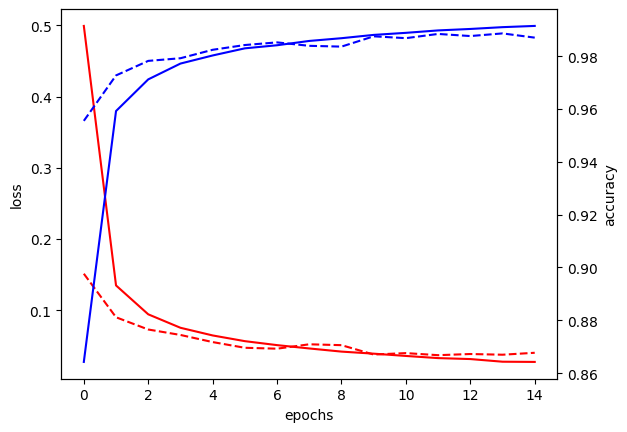

In [9]:
fig, ax1 = plt.subplots()

ax1.set_ylabel('loss', )
ax1.plot(model.history.history['loss'], 'r', label='training')
ax1.plot(model.history.history['val_loss'], 'r--', label='validation')
ax1.set_xlabel('epochs')

ax2 = ax1.twinx()
ax2.set_ylabel('accuracy', )
ax2.plot(model.history.history['accuracy'], 'b', label='training')
ax2.plot(model.history.history['val_accuracy'], 'b--', label='validation')

ax2.set_xlabel('epochs')
plt.show()

* Now make some prediction based on the model we trained 

In [10]:
example_images = []
example_labels = []

for x, y in test_ds.take(10):
    example_images.append(x.numpy())
    example_labels.append(y.numpy())

example_images = np.concatenate(example_images, axis = 0)    
example_labels = np.concatenate(example_labels, axis = 0)    

* plot prediction along with image 

In [11]:
pred = model.predict(example_images, verbose=0)

In [12]:
def plot(image, pred):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]}) 
    ax1.imshow(image, cmap='binary')
    ax2.set_xlim(0,9)
    ax2.set_ylim(0,1)
    ax2.bar(np.arange(10), pred)
    plt.show()

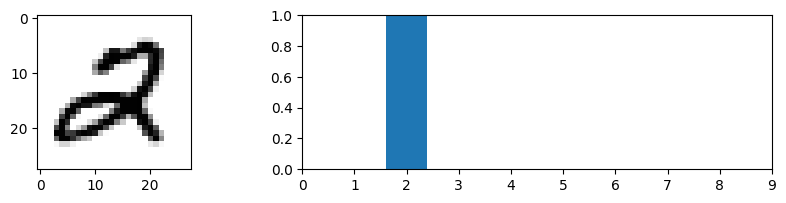

In [13]:
plot(example_images[0], pred[0])

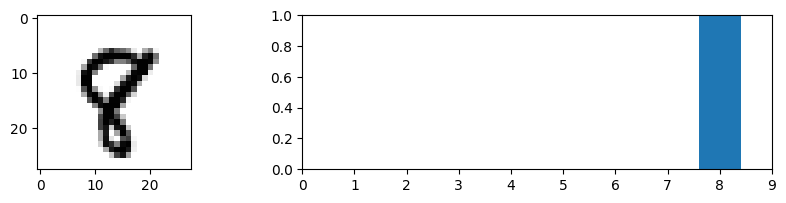

In [14]:
plot(example_images[122], pred[122])

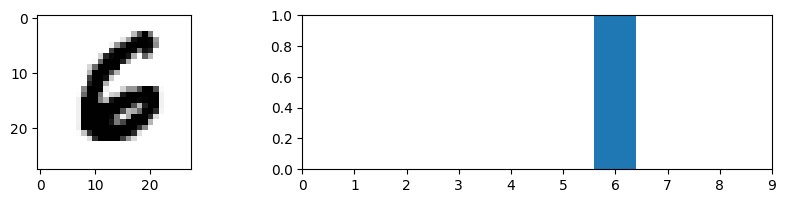

In [15]:
plot(example_images[5], pred[5])

* Add some noise to an image and see how the model predicts

In [16]:
noise_vector = np.random.uniform(size = (28, 28, 1), 
                                 low = 0, high = 0.5)
noisy_image = np.clip(example_images[0] + noise_vector*2, 0, 1)

* In the last example the model predicts the highest value for class 8
* How can we quantifiy the uncertainity on this prediction?
* In order to introduce uncertainties lets use `OneHotCategorical()` layer from TensorFlow Probability
`OneHotCategorical()` is designed for handling categorical distributions, this layer outputs a one-hot encoded representation of categorical data. Essentially, it can be used to parameterize a categorical distribution, where the output represents the probability of each category. The output of `OneHotCategorical()` is a probability distribution over the categorical classes. <br>
An important aspect is to explain the difference between and a `Dense()` layer with `softmax` which is often refered as the probability of a given class. Unlike `OneHotCategorical()`, this setup is deterministic. It provides the most probable class based on the learned weights, but it doesn't model the distribution of the classes. <br>
* Now let's introduce `OneHotCategorical()` into our CNN

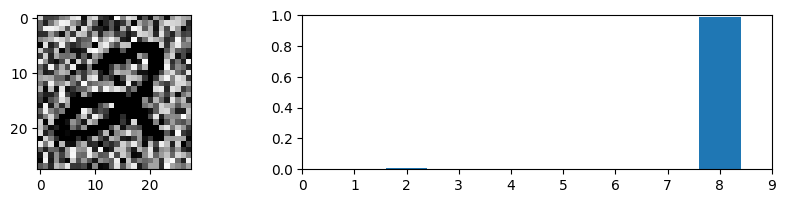

In [17]:
pred_wn = model.predict(noisy_image.reshape(1,28,28,1), verbose=0)
plot(noisy_image, pred_wn[0])

In [18]:
model_wUnc = Sequential(name='CNN_withOneHotCat')

# First convolutional layer
model_wUnc.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_wUnc.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model_wUnc.add(Conv2D(64, (3, 3), activation='relu'))
model_wUnc.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model_wUnc.add(Conv2D(128, (3, 3), activation='relu'))

# Flatten the output of the convolutional layers
model_wUnc.add(Flatten())

# Dense layer for classification with TensorFlow Probability 
model_wUnc.add(Dense(tfpl.OneHotCategorical.params_size(10)))  
model_wUnc.add(tfpl.OneHotCategorical(10))


In [19]:
model_wUnc.summary()

Model: "CNN_withOneHotCat"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 1152)        

In [20]:
def nll(y_true, y_pred):
    """
    The log-likelihood of a sample y_true given a predicted distribution y_pred 
    measures how probable the true sample is according to the predicted distribution. 
    It's a way of assessing how well the predicted distribution aligns with the actual data.
    By taking the negative of the log-likelihood, the measure is turned into a loss: higher values of this
    loss correspond to worse predictions (i.e., the true data being less likely under the predicted distribution).
    Minimizing this loss during training encourages the model to adjust its parameters to make the true data more
    likely under the predicted distribution
    """
    return -y_pred.log_prob(y_true)

In [21]:
model_wUnc.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 1e-4),
              loss=nll,
              metrics=['accuracy'])

In [22]:
history = model_wUnc.fit(train_ds, epochs = 15, validation_data = test_ds)

Epoch 1/15
938/938 [==============================] - 17s 17ms/step - loss: 0.5414 - accuracy: 0.7287 - val_loss: 0.1681 - val_accuracy: 0.9064
Epoch 2/15
938/938 [==============================] - 17s 18ms/step - loss: 0.1476 - accuracy: 0.9207 - val_loss: 0.1019 - val_accuracy: 0.9412
Epoch 3/15
938/938 [==============================] - 17s 18ms/step - loss: 0.1018 - accuracy: 0.9451 - val_loss: 0.0795 - val_accuracy: 0.9535
Epoch 4/15
938/938 [==============================] - 16s 17ms/step - loss: 0.0805 - accuracy: 0.9554 - val_loss: 0.0611 - val_accuracy: 0.9643
Epoch 5/15
938/938 [==============================] - 16s 17ms/step - loss: 0.0679 - accuracy: 0.9623 - val_loss: 0.0547 - val_accuracy: 0.9682
Epoch 6/15
938/938 [==============================] - 16s 17ms/step - loss: 0.0590 - accuracy: 0.9679 - val_loss: 0.0492 - val_accuracy: 0.9746
Epoch 7/15
938/938 [==============================] - 17s 18ms/step - loss: 0.0525 - accuracy: 0.9708 - val_loss: 0.0442 - val_accuracy:

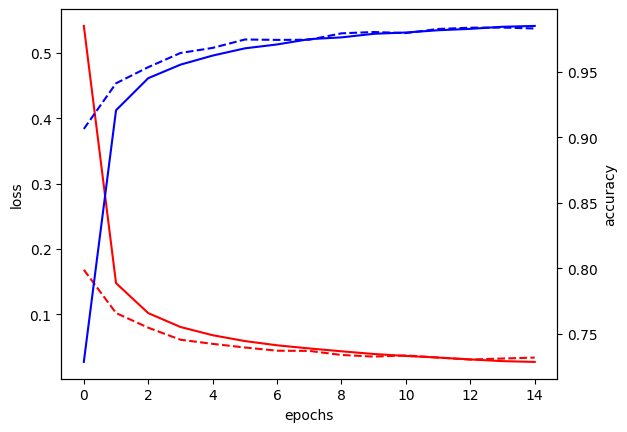

In [23]:
fig, ax1 = plt.subplots()

ax1.set_ylabel('loss', )
ax1.plot(model_wUnc.history.history['loss'], 'r', label='training')
ax1.plot(model_wUnc.history.history['val_loss'], 'r--', label='validation')
ax1.set_xlabel('epochs')

ax2 = ax1.twinx()
ax2.set_ylabel('accuracy', )
ax2.plot(model_wUnc.history.history['accuracy'], 'b', label='training')
ax2.plot(model_wUnc.history.history['val_accuracy'], 'b--', label='validation')

ax2.set_xlabel('epochs')
plt.show()

* Now since the the output of `OneHotCategorical()` is a probability distribution over the categorical classes
* We can calculate the mean and standard deviation, then we can use the standard deviation as upper limit

In [24]:
mean = model_wUnc(example_images).mean().numpy()
stddev = model_wUnc(example_images).stddev().numpy()

In [25]:
def plot_wstddev(image, mean, stddev):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 2),
                                   gridspec_kw={'width_ratios': [2, 4]}) 
    ax1.imshow(image, cmap='binary')
    ax2.set_xlim(0,9)
    ax2.set_ylim(0,1)
    plt.errorbar(np.arange(10), mean, yerr=stddev, uplims=True, marker='o', linestyle='')
    plt.show()

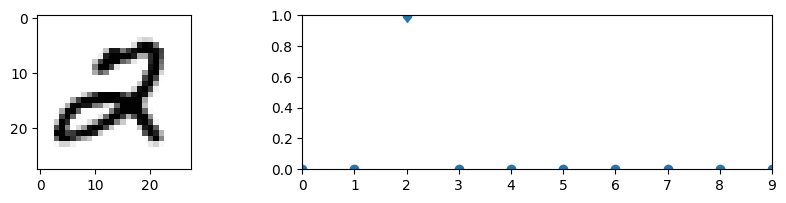

In [26]:
plot_wstddev(example_images[0], mean[0], stddev[0])

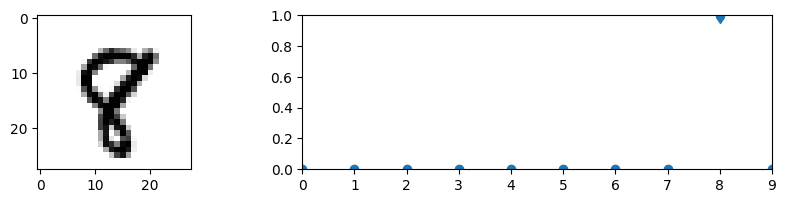

In [27]:
plot_wstddev(example_images[122], mean[122], stddev[122])

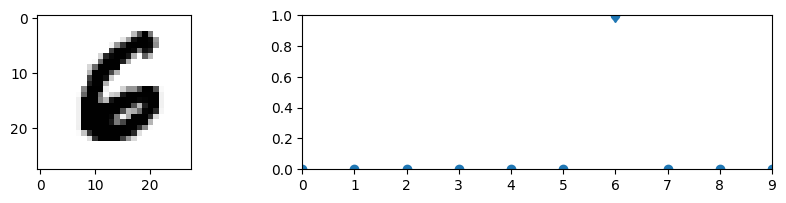

In [28]:
plot_wstddev(example_images[5], mean[5], stddev[5])

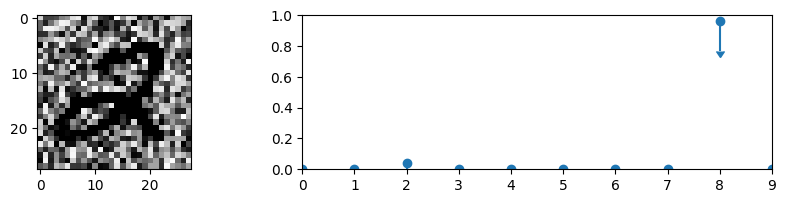

In [41]:
mean_wn = model_wUnc(noisy_image.reshape(1,28,28,1)).mean().numpy()
stddev_wn = model_wUnc(noisy_image.reshape(1,28,28,1)).stddev().numpy()

plot_wstddev(noisy_image, mean_wn[0], stddev_wn[0])

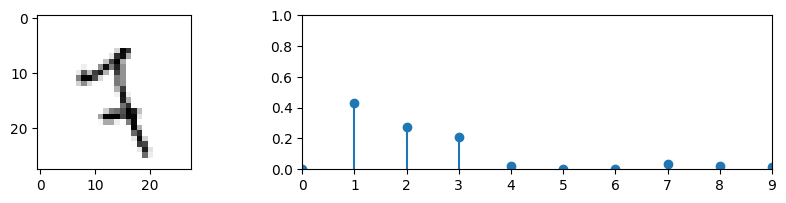

In [44]:
plot_wstddev(example_images[33], mean[33], stddev[33])

* By examining the 'error bars' or the standard deviations, we can assert that the predictions for various classes fall within their respective standard deviations.
* This quantification of uncertainty in the predictions enables more informed decision-making

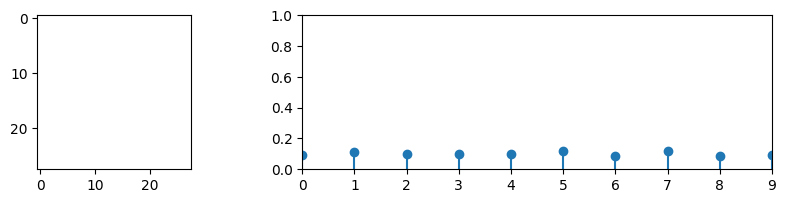

In [55]:
mean_zeros = model_wUnc(np.zeros((1,28,28,1))).mean().numpy()
stddev_zeros = model_wUnc(np.zeros((1,28,28,1))).stddev().numpy()

plot_wstddev(np.zeros((1,28,28,1))[0], mean_zeros[0], stddev_zeros[0])